In [6]:
#1)divide into 3s data
#2)Then get a 4D array for all 708 glitches
# X. Li 2022 - 2024

import  numpy as np
import  scipy.special
from    typing import Union, Optional

sqrt2pi = np.sqrt(2*np.pi)
sqrt1pi = np.sqrt(np.pi)

def linear_JCTFT(   ts              : np.ndarray        , 
                    sample_rate     : Union[int, float] , 
                    L               : int,
                    C               : Union[int, float] ,
                    frange          : Union[list[int, int]]       = [30, 300]  , 
                    frate           : Union[int, float] = 1         , 
                    alpha           : int               = 1         ,
                    downsample      : Optional[int]     = None      ,
                    win_template    : Optional[np.ndarray]        = None
                    ) -> np.ndarray:
    '''Compute the Linear Joint Chirp Rate Time Frequency Transform of a time 
    series data array

    Parameters
    ----------
    ts (np.ndarray)         : time series data array
    sample_rate (int)       : sample rate of the time series
    L (int)                 : the number of chirp rate parameters
    C (int, float)          : chirp rate scaling coefficient
    frange (list[int, int]) : frequency range to compute the S Transform
    frate (int)             : frequency resolution of the S Transform
    alpha (int)             : normalization factor for the Gaussian window
    downsample (int)        : downsample factor for the S Transform
    win_template (np.ndarray): window template for the S Transform

    Returns
    -------
    vol (np.ndarray)        : linear JCTFT spectrogram array

    NOTE:
    * Each Time-Frequency spectrogram is computed using the S Transform
    * Refer to the S Transform for more details
    '''

    # see the S Transform for more details
    # https://github.com/xli2522/S-Transform
    length          : int           = len(ts)       # length of the input ts
    Nfreq           : list[int, int]= [int(frange[0]*length/sample_rate), 
                                        int(frange[1]*length/sample_rate)]
    tsVal           : np.ndarray    = np.copy(ts)   # copy of the input ts

    # number of freq bins
    number_freq     : int           = abs(int(Nfreq[1] - Nfreq[0]))  

    _scaled_frate   : int           = int(np.ceil(frate*length/sample_rate)) 

    # FFT of the original time series
    tsFFT           : np.ndarray    = np.fft.fft(tsVal)

    # time domain downsampling
    if downsample   ==  None:
        tsFFT_cut   : np.ndarray    = np.concatenate((tsFFT, tsFFT))
        downsampled_length          : int       = len(tsFFT)
        normalize_cut               : int       = 1

    elif isinstance(downsample, int):
        # positive half
        tsFFT_positive              : np.ndarray= tsFFT[:Nfreq[1]]             
        # negative half   
        tsFFT_negative              : np.ndarray= tsFFT[-Nfreq[1]:len(tsFFT)]     
        if downsample < 2*number_freq:
            # perform the max allowed lower and higher frequency cut-off
            pass
        else:
            # 0 padding to make up for the high and low-passed freq elements
            tsFFT_positive          : np.ndarray= np.concatenate((
                tsFFT_positive, 
                np.zeros(downsample//2-number_freq)
                ))  

            tsFFT_negative          : np.ndarray= np.concatenate((
                np.zeros(downsample//2-number_freq), 
                tsFFT_negative
                ))

        # connect high and low-passed coefficients
        tsFFT_cut   : np.ndarray    = np.concatenate(
            (tsFFT_positive, tsFFT_negative))
        downsampled_length          : int       = len(tsFFT_cut)

        # normalization factor
        normalize_cut = 1 - downsampled_length/length

    # prepare the stacked vector for the S Transform convolution operation
    vec             : np.ndarray    = np.hstack((tsFFT_cut, tsFFT_cut))      
    # vec             : np.ndarray    = tsFFT_cut

    volume          : np.ndarray    = np.zeros(
                    ( 2*L + 1, 
                      int(number_freq/_scaled_frate)+1,
                      downsampled_length
                    ), dtype='c8')
    
    # Temporary variable for the frequency scaling, will be removed later
    # BEGIN of temporary variables
    _scaled_sigma   : int           = 30
    mu              : int           = 0.005
    # END of temporary variables

    for l in range(-L, L+1):
        for i in range(_scaled_frate, number_freq+1, _scaled_frate):       
            
            volume[l,
                   int(i/_scaled_frate),
                   :] = np.fft.ifft(
                    vec[Nfreq[0]+i:Nfreq[0]+i+downsampled_length]
                    *linear_freq_win(downsampled_length, 
                                     Nfreq, 
                                     l*C,_scaled_sigma+mu*i)*normalize_cut)
    # final IFFT with rescaled amplitudes
    # volume = np.fft.ifft(volume*normalize_cut)
    # here we add the average values to the 0th row
    volume[0,0,:] = np.mean(ts)*np.ones(volume[0,0,:].shape)

    return volume


def linear_freq_win(length, _scaled_frange, _scaled_gamma, _scaled_freq,
                        amp=1):
    '''The frequency domain linear chirp window function.
    Inputs:
            length              length of the window function
            _scaled_frange      frequency range (in frequency number)
            _scaled_gamma       chirp rate gamma
            _scaled_freq        frequency STD control parameter
            amp                 amplitude scaling parameter 
    Output:
            win        window function template  
    Note:
            discrete frequency number and time number refer to discrete bin 
            numbers 
    '''
    # discrete frequency scale in frequency number
    alpha = np.linspace(-_scaled_frange[1], 
	                    	_scaled_frange[1], length)

    # determine frequency number and chirp rate number
    _scaled_freq = _scaled_freq/length*_scaled_frange[1]*2
    _scaled_gamma = _scaled_gamma/length*_scaled_frange[1]*2

    # parameters for the complex frequency domain JCTFT window function

    c = _scaled_freq**2/2; d = 2*np.pi*_scaled_gamma 
    k = c+1j*d; sqrtk = np.sqrt(k)

    A = _scaled_freq/sqrt2pi            # partial normalization factor

    # the v4 window with signed gamma (minor changes expected)
    win = amp*A*(np.exp(-np.pi**2*alpha**2/k)*sqrt1pi/2/sqrtk*
                            (1-scipy.special.erf(1j*np.pi*alpha/sqrtk)))

    win = np.nan_to_num(win)		# slow		
    # reshape the window function to match the JCTFT computation procedure
    win = np.hstack((win,win))[length//2:length//2+length]

    return win

#Downsample resolving
#Width of window function to be changed if needed

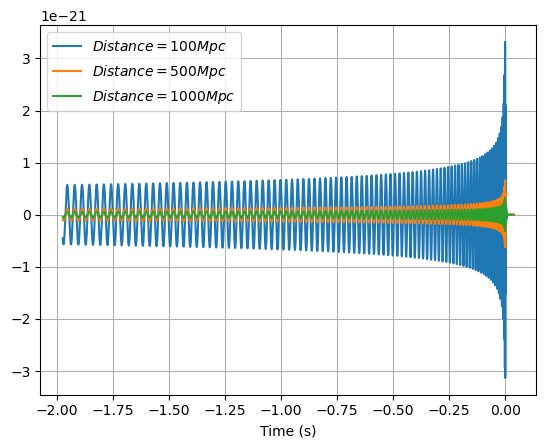

[-1.97555435 -1.97531021 -1.97506607 ...  0.0373851   0.03762924
  0.03787338]


In [5]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d)
    
    x=hp+hc
    
    pylab.plot(hp.sample_times, x, label='$Distance=%sMpc$' % d)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()
print(hp.sample_times)

In [9]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=1200)
    
x=hp+hc

rate = 2048; t = 2 
L=30; C=1; frange=[30,300]; downsample=600; frate=1

volume = linear_JCTFT(x, rate, 
                L, C, frange, frate, 1, downsample)


print(volume.shape)

# Compute the statistics
largest_positive = np.max(volume)
largest_negative = np.min(volume)
mean_value = np.mean(volume)
median_value = np.median(volume)

# Print the statistics
print(f"Largest positive number-as such: {largest_positive}")
print(f"Largest negative number: {largest_negative}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
difference=volume[0:29] - volume[60:31:-1]
print(difference.shape)
# Compute the statistics
largest_positive = np.max(difference)
largest_negative = np.min(difference)
mean_value = np.mean(difference)
median_value = np.median(difference)

/tmp/ipykernel_12486/4270000876.py:160: RuntimeWarning: invalid value encountered in multiply
  win = amp*A*(np.exp(-np.pi**2*alpha**2/k)*sqrt1pi/2/sqrtk*


(61, 218, 2416)
Largest positive number-as such: (4.08536705545487e-23-3.525176021843441e-24j)
Largest negative number: (-4.054478733394398e-23-1.5327286553962e-23j)
Mean: (4.260615023125341e-27+2.3421086142273446e-26j)
Median: 0j
(29, 218, 2416)


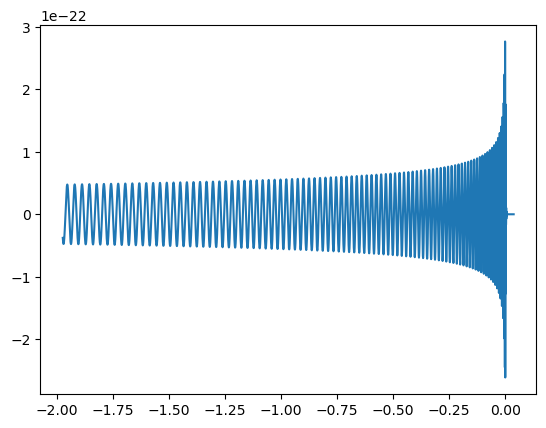

In [11]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=1200)
    
x=hp+hc

pylab.plot(hp.sample_times, x, label='$Distance=%sMpc$' )